In [103]:
# Импортируем все необходимые библиотеки

import os
import re
import string
import emoji
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import os
import glob
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [109]:
def read_text_files(folder):
    texts = []
    for filepath in glob.glob(os.path.join(folder, '*.txt')):
        with open(filepath, 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts

# Предобработка текста
def preprocess_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Удаляем пунктуацию
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Удаляем числа
    text = re.sub(r'\d+', '', text)
    
    # Удаляем специальные символы и эмодзи
    text = emoji.replace_emoji(text, replace='')
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Удаляем стоп-слова
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Лемматизация
    text = ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    return text

# Укажите путь к папке, где находятся извлеченные файлы
folder_path = '\extracted_files'

# Чтение и предобработка текстов
texts = read_text_files(folder_path)
preprocessed_texts = [preprocess_text(text) for text in texts]

# Проверка количества текстов
print(f"Количество предобработанных текстов: {len(preprocessed_texts)}")
# print(preprocessed_texts)  # Выводим некоторые тексты для проверки

Количество предобработанных текстов: 200


In [107]:
# Загружаем модель для эмбеддингов
model = SentenceTransformer('all-MiniLM-L6-v2')

In [108]:
# Преобразуем текст в эмбеддинги
embeddings = model.encode(preprocessed_texts)

C:\Users\Victus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Victus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Victus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Victus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Wi

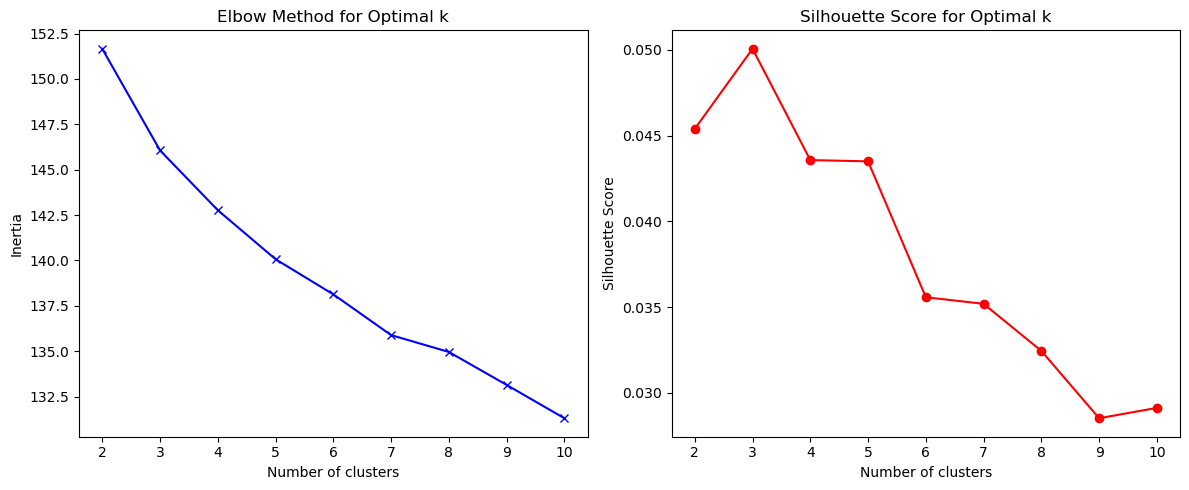

In [112]:
# Метод локтя
def plot_elbow_method(embeddings):
    inertia = []
    silhouette_scores = []
    K = range(2, 11)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
        kmeans.fit(embeddings)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(score)
    
    # Построение графика для метода локтя
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    
    # Построение графика для коэффициента силуэта
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'ro-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения графиков
plot_elbow_method(embeddings)




In [113]:
# Укажите количество кластеров по результатам анализа
n_clusters = 3  # Измените по результатам метода локтя и силуэта
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(embeddings)
clusters = kmeans.labels_

print(f"Кластеры: {clusters}")

C:\Users\Victus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Кластеры: [2 2 2 2 2 2 2 1 0 2 2 1 1 0 2 0 0 1 0 2 2 1 0 2 0 2 0 0 0 2 2 1 2 2 1 2 2
 2 2 1 1 2 2 2 2 2 2 1 1 2 2 1 2 1 2 2 2 2 0 2 2 2 1 1 1 0 2 1 0 1 1 0 2 0
 1 2 2 1 0 1 2 2 2 2 0 2 2 2 0 2 2 1 2 1 2 1 1 2 2 2 0 0 2 1 2 1 2 2 1 0 2
 0 1 1 0 2 2 2 2 2 0 2 2 1 1 2 1 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 1 2 0 2 2 2 2 2 2 2 0 2 1 1 2 1 1 1 2 0 2 2 2 2 2 1 1 0 0 1 2 2 1 0 0 2 1
 2 1 1 2 0 1 2 1 2 2 0 2 1 1 0]


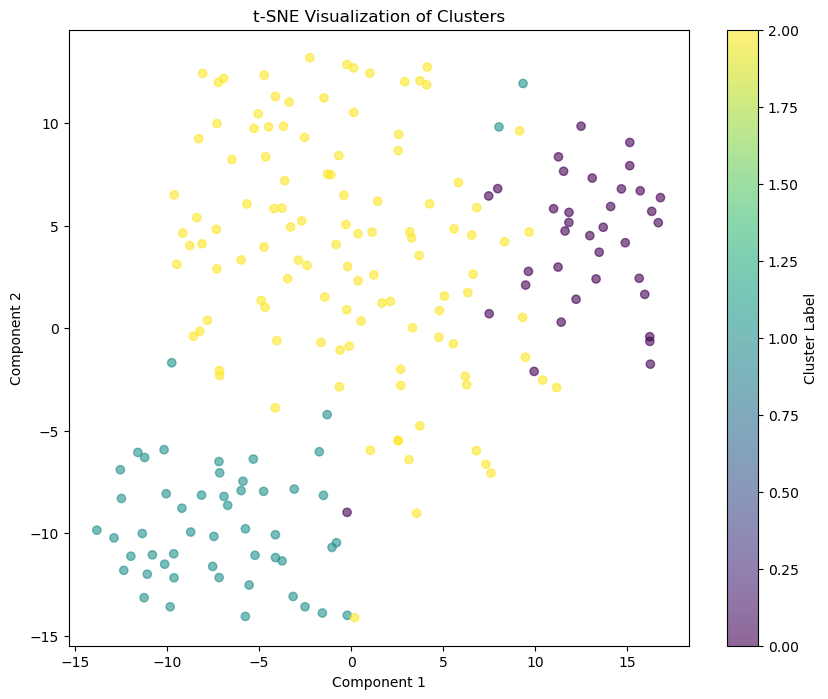

In [114]:
import matplotlib.pyplot as plt


# Визуализация кластеров с помощью t-SNE
def visualize_clusters(embeddings, clusters):
    tsne = TSNE(n_components=2, random_state=0, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

# Вызов функции для визуализации кластеров
visualize_clusters(embeddings, clusters)


C:\Users\Victus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


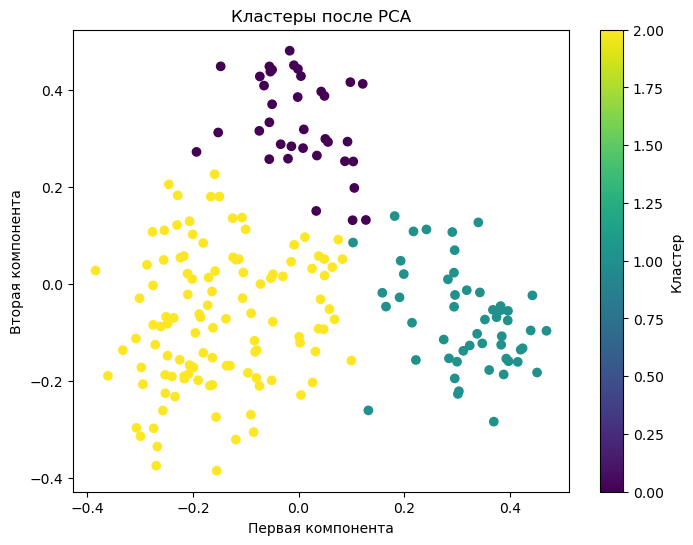

In [116]:
# Обучаем KMeans с оптимальным числом кластеров
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
labels = kmeans.fit_predict(embeddings)

# Применяем PCA для уменьшения размерности до 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

# Визуализируем кластеры
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Кластеры после PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Кластер')
plt.show()

In [117]:
# Проверка формы эмбеддингов
print(embeddings.shape)  # Должно быть (n_samples, n_features)

# Если вы получили 1D массив, возможно, вам нужно преобразовать его
# if len(embeddings.shape) == 1:
#     embeddings = embeddings.reshape(-1, 1)  # Преобразование в 2D, если нужно


(200, 384)


In [118]:
print(embeddings)


[[ 8.39632191e-03  1.45644117e-02  7.69611746e-02 ... -8.13363269e-02
  -1.68044679e-02  2.97066253e-02]
 [ 5.24335764e-02 -5.63736036e-02 -3.21634524e-02 ... -1.60731263e-02
  -5.45563921e-02  8.00746903e-02]
 [-1.06297415e-02  3.71913798e-02  5.68086244e-02 ...  5.10151917e-03
   1.80314090e-02  8.56788829e-02]
 ...
 [-6.26511648e-02  1.48330316e-01 -2.90141497e-02 ... -4.64911908e-02
   4.60677293e-05  2.12954525e-02]
 [-4.31016311e-02  4.88696136e-02  4.86729667e-02 ...  5.03310673e-02
   3.29845771e-02  7.71568641e-02]
 [ 5.30436188e-02  1.56305227e-02 -2.17099022e-02 ...  4.64317203e-02
   1.45003544e-02 -1.96061865e-03]]


In [123]:
# Создаем словарь для хранения документов по кластерам
clusters_dict = {i: [] for i in range(n_clusters)}  # n_clusters - количество кластеров

# Заполняем словарь документами
for idx, label in enumerate(clusters):
    clusters_dict[label].append(texts[idx])  # texts - это исходные текстовые документы

# Выводим документы по кластерам
for cluster_id, documents in clusters_dict.items():
    print(f"\nDocuments in cluster {cluster_id}:")
    for doc in documents:
        print(doc)


Documents in cluster 0:
Topic: BBC reporters' log

Text: BBC correspondents record events in the Middle East and their thoughts as the funeral of the Palestinian leader Yasser Arafat takes place.
Topic: Rebels return to 'cleared' areas

Text: In Fallujah, US forces are going through 50,000 houses one by one. But insurgents are coming back.
Topic: At least 90 dead, 77 missing in China rainstorms

Text: BEIJING : At least 90 people were killed and 77 were missing in torrential storms lashing southwest China, disaster relief officials said.
Topic: Brazilian Soldier Wounded in Haiti Unrest

Text: &lt;p&gt;&lt;/p&gt;&lt;p&gt; By Joseph Guyler Delva&lt;/p&gt;&lt;p&gt; GONAIVES, Haiti (Reuters) - A Brazilian soldier with theU.N. peacekeeping force in Haiti was shot and wounded Saturdaywhen peacekeepers and local police faced gunfire in a crackdownon armed gangs in the Haitian capital.&lt;/p&gt;
Topic: Does Tsvangirai outcome suit Mugabe?

Text: On hearing the verdict there was a broad smile 

In [126]:
# Функция для чтения текста из файла
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Функция для классификации нового документа
def classify_new_document(file_path, model, kmeans, embeddings):
    new_document = read_text_file(file_path)  # Читаем текст из файла
    new_embedding = model.encode([preprocess_text(new_document)])
    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(new_embedding)
    cluster = kmeans.predict(new_embedding)
    return cluster[0], distances[0][0]  # Возвращаем кластер и расстояние до ближайшего

# Пример использования
new_doc_path = '\Emb.txt'  # Замените на путь к вашему текстовому файлу
predicted_cluster, distance = classify_new_document(new_doc_path, model, kmeans, embeddings)
print(f"The new document belongs to cluster: {predicted_cluster}, distance: {distance}")


The new document belongs to cluster: 1, distance: 0.5430532693862915
